# Emotional Arcs für Soundtracks

**Ziel:** Betrachtung von Sentiments bzw. Emotionen im Verlauf eines Filmes auf Basis der Filmmusik analog zu textbasierten Ansätzen

Referenzpaper:
* The emotional arcs of stories are dominated by six basic shapes (2016)
* A Survey on Sentiment and Emotion Analysis for Computational Literary Studies. | 4.5.1 Emotion Flow Analysis (2019)

## Imports

Spotify Related

In [1]:
from spotify_client import *

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
client_id = "85434f2d38ba4509924f3940ec3b40ed"
client_secret = "3bb1e3237c334e95b1db5244740d2fc0"

In [3]:
SPOTIPY_CLIENT_ID='85434f2d38ba4509924f3940ec3b40ed'
SPOTIPY_CLIENT_SECRET='3bb1e3237c334e95b1db5244740d2fc0'

In [4]:
spotify = SpotifyAPI(client_id, client_secret)

In [5]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIPY_CLIENT_ID,SPOTIPY_CLIENT_SECRET))

IMDB

In [6]:
import imdb

In [7]:
ia = imdb.IMDb()

Data Processing

In [8]:
import json
import requests
import re
import sys

In [9]:
import pandas as pd
import numpy as np

Visualisierungen

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Using plotly.express
import plotly.express as px

## Schritt 1: Korpus erstellen

Zielformat pro Soundtrack:

`{albumid: SpotifyAlbumID, albumtitel: Albumtitel, filmtitel: Filmtitel (nach Regex), valence: [Valence Scores], energy: [Energy Scores], genres: [IMDB genres]}` 

### Soundtracks Retrieval

Methode für die Suche

In [12]:
def search(query=None, search_type='artist', limit=20, offset=0):
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
            print(query)
        query_params = urlencode({"q": query, "type": search_type.lower(), "limit": limit, "offset": offset})
        print(query_params)
        return spotify.base_search(query_params)

Retrieval von 1000 Soundtracks | Level: Albuminformationen

Hinweis: Limit pro Suchanfrage sind 50 Alben; daher 20 * 50 Alben mit Offset abgerufen.

In [13]:
result_lists=[]
for i in range (0,951,50):
    results = search({"album":"Original Motion Picture Soundtrack"},search_type="album", limit=50, offset=i)
    result_lists.append(results)

album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=0
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=50
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=100
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=150
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=200
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=250
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=300
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=350
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+

In [14]:
len(result_lists)

20

**Albuminformationen für ein Beispielalbum**

In [15]:
result_lists[0]['albums']['items'][0].keys()

dict_keys(['album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])

In [16]:
result_lists[0]['albums']['items'][0]['id']

'4M07HWIlZr7zoXoxDHR5mz'

In [17]:
result_lists[0]['albums']['items'][0]['name']

'Frozen 2 (Original Motion Picture Soundtrack/Deluxe Edition)'

### Transform to DataFrame [for better Processing]

In [18]:
df = pd.DataFrame(result_lists[0]['albums']['items'])

In [19]:
for i in range(1,20):
    df = df.append(pd.DataFrame(result_lists[i]['albums']['items']),ignore_index=True)

In [20]:
df.describe()

total_tracks
count     1000.0000
mean        17.4850
std          9.6814
min          1.0000
25%         11.0000
50%         16.0000
75%         22.2500
max         88.0000

### Methodenblock für die Anreicherung der Albuminformationen

Anmerkung: Methode zur Aufbereitung der Titel für IMDB Retrieval erforderlich, da ohne Aufbereitung getestet, hat nicht funktioniert.

In [21]:
def regex_reduce_title(row):
    title = row['name']
    title = re.sub('(\([a-zA-Z /\[\].&""]+\))', '', title)
    title = re.sub('(Original Motion Picture Soundtrack)', '', title)
    title = re.sub("(\[[a-zA-Z ']+\])",'',title)
    title = re.sub('\[\]','',title)
    title = re.sub('-','',title)
    title = re.sub('/','',title)   
    return title

In [22]:
def create_valence_list(row,spotipy_client):
    albumid = row['id']
    valence_list = []
    for item in spotipy_client.album_tracks(albumid)['items']:
        trackid = item['id']
        try:
            valence_list.append(spotipy_client.audio_features(item['id'])[0]['valence'])
        except TypeError:
            continue
    return valence_list

In [23]:
def create_energy_list(row,spotipy_client):
    albumid = row['id']
    energy_list = []
    for item in spotipy_client.album_tracks(albumid)['items']:
        trackid = item['id']
        try:
            energy_list.append(spotipy_client.audio_features(item['id'])[0]['energy'])
        except TypeError:
            continue
    return energy_list

In [24]:
def add_imdb_genres(row,imdb_client):
    title = row['reduced_title']
    movie = imdb_client.search_movie(title, results=1)
    try:
        movie_id = movie[0].movieID
        genres = imdb_client.get_movie_main(movie_id)['data']['genres']
    except IndexError:
        genres = None
    return genres

### Anreicherung des DataFrames

In [ ]:
df['reduced_title'] = df.apply(lambda row: regex_reduce_title(row), axis=1)

In [ ]:
df['valence_list'] = df.apply(lambda row: create_valence_list(row,sp), axis=1)

In [ ]:
df['energy_list'] = df.apply(lambda row: create_energy_list(row,sp), axis=1)

In [ ]:
df['genres'] = df.apply(lambda row: add_imdb_genres(row,ia), axis=1)

In [ ]:
df.to_csv('soundtracksData.csv', index = False)

In [25]:
df = pd.read_csv('soundtracksData.csv')

In [26]:
df['valence_list'] = df['valence_list'].apply(json.loads)

In [27]:
df['energy_list'] = df['energy_list'].apply(json.loads)

In [28]:
df.head()

album_type                                            artists  \
0        album  [{'external_urls': {'spotify': 'https://open.s...   
1  compilation  [{'external_urls': {'spotify': 'https://open.s...   
2  compilation  [{'external_urls': {'spotify': 'https://open.s...   
3  compilation  [{'external_urls': {'spotify': 'https://open.s...   
4        album  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  \
0  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
1  ['AE', 'AR', 'AU', 'BH', 'BO', 'BR', 'CA', 'CL...   
2  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
3  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
4  ['AD', 'AE', 'AR', 'AU', 'BE', 'BH', 'BO', 'BR...   

                                       external_urls  \
0  {'spotify': 'https://open.spotify.com/album/4M...   
1  {'spotify': 'https://open.spotify.com/album/6p...   
2  {'spotify': 'https://open.spotify.com/album/7a...   
3  {'spotify': 'https://open.spotify.com/album/7l...   
4  {'spotify': 'https://open.spotify.com/album/65...   

                                                href                      id  \
0  https://api.spotify.com/v1/albums/4M07HWIlZr7z...  4M07HWIlZr7zoXoxDHR5mz   
1  https://api.spotify.com/v1/albums/6pZj4nvx6lV3...  6pZj4nvx6lV3ulIK3BSjvs   
2  https://api.spotify.com/v1/albums/7ayBZIe1FHkN...  7ayBZIe1FHkNv0T5xFCX6F   
3  https://api.spotify.com/v1/albums/7lZs5r4oQV2n...  7lZs5r4oQV2nutddffLrg0   
4  https://api.spotify.com/v1/albums/65ayND23IInU...  65ayND23IInUPHJKsaAqe7   

                                              images  \
0  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
1  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
2  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
3  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
4  [{'height': 640, 'url': 'https://i.scdn.co/ima...   

                                                name release_date  \
0  Frozen 2 (Original Motion Picture Soundtrack/D...   2019-11-15   
1  Moana (Original Motion Picture Soundtrack/Delu...   2016-11-18   
2  The Greatest Showman (Original Motion Picture ...   2017-12-08   
3  Frozen (Original Motion Picture Soundtrack / D...   2013-01-01   
4        TROLLS (Original Motion Picture Soundtrack)   2016-09-23   

  release_date_precision  total_tracks   type  \
0                    day            46  album   
1                    day            59  album   
2                    day            11  album   
3                    day            59  album   
4                    day            13  album   

                                    uri          reduced_title  \
0  spotify:album:4M07HWIlZr7zoXoxDHR5mz              Frozen 2    
1  spotify:album:6pZj4nvx6lV3ulIK3BSjvs                 Moana    
2  spotify:album:7ayBZIe1FHkNv0T5xFCX6F  The Greatest Showman    
3  spotify:album:7lZs5r4oQV2nutddffLrg0                Frozen    
4  spotify:album:65ayND23IInUPHJKsaAqe7                TROLLS    

                                        valence_list  \
0  [0.195, 0.299, 0.274, 0.434, 0.311, 0.293, 0.1...   
1  [0.188, 0.18, 0.748, 0.108, 0.391, 0.231, 0.67...   
2  [0.4, 0.0998, 0.102, 0.235, 0.31, 0.227, 0.1, ...   
3  [0.191, 0.166, 0.43, 0.537, 0.371, 0.409, 0.68...   
4  [0.341, 0.7, 0.595, 0.592, 0.567, 0.173, 0.65,...   

                                         energy_list  \
0  [0.204, 0.543, 0.405, 0.326, 0.0885, 0.478, 0....   
1  [0.405, 0.203, 0.656, 0.307, 0.578, 0.449, 0.7...   
2  [0.824, 0.312, 0.139, 0.77, 0.795, 0.394, 0.70...   
3  [0.481, 0.121, 0.411, 0.637, 0.485, 0.233, 0.3...   
4  [0.58, 0.832, 0.82, 0.713, 0.218, 0.178, 0.91,...   

                                              genres  
0  ['Animation', 'Adventure', 'Comedy', 'Family',...  
1  ['Animation', 'Adventure', 'Comedy', 'Family',...  
2                  ['Biography', 'Drama', 'Musical']  
3  ['Animation', 'Adventure', 'Comedy', 'Family',...  
4  ['Animation', 'Adventure', 'Comedy', '

### Zwischenschritt: Extremwerte für Trackanzahl filtern

Begründung: weniger als 10 Lieder sind i.d.R. keine vollständigen Alben und mehr als 30 sind tendenziell Deluxe Alben mit mehr als einer Version pro Track.

In [29]:
df = df[(df['total_tracks']>9)&(df['total_tracks']<30)]

In [30]:
df.reset_index(drop=True,inplace=True)

In [31]:
df

album_type                                            artists  \
0    compilation  [{'external_urls': {'spotify': 'https://open.s...   
1          album  [{'external_urls': {'spotify': 'https://open.s...   
2          album  [{'external_urls': {'spotify': 'https://open.s...   
3    compilation  [{'external_urls': {'spotify': 'https://open.s...   
4    compilation  [{'external_urls': {'spotify': 'https://open.s...   
..           ...                                                ...   
728        album  [{'external_urls': {'spotify': 'https://open.s...   
729        album  [{'external_urls': {'spotify': 'https://open.s...   
730  compilation  [{'external_urls': {'spotify': 'https://open.s...   
731        album  [{'external_urls': {'spotify': 'https://open.s...   
732        album  [{'external_urls': {'spotify': 'https://open.s...   

                                     available_markets  \
0    ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
1    ['AD', 'AE', 'AR', 'AU', 'BE', 'BH', 'BO', 'BR...   
2                                               ['US']   
3    ['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...   
4    ['AE', 'AL', 'BA', 'BE', 'BG', 'BH', 'BR', 'CA...   
..                                                 ...   
728   ['BE', 'CA', 'FR', 'LU', 'MC', 'MX', 'NL', 'US']   
729  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
730  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
731  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
732  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   

                                         external_urls  \
0    {'spotify': 'https://open.spotify.com/album/7a...   
1    {'spotify': 'https://open.spotify.com/album/65...   
2    {'spotify': 'https://open.spotify.com/album/1j...   
3    {'spotify': 'https://open.spotify.com/album/4w...   
4    {'spotify': 'https://open.spotify.com/album/2P...   
..                                                 ...   
728  {'spotify': 'https://open.spotify.com/album/20...   
729  {'spotify': 'https://open.spotify.com/album/3j...   
730  {'spotify': 'https://open.spotify.com/album/4O...   
731  {'spotify': 'https://open.spotify.com/album/2L...   
732  {'spotify': 'https://open.spotify.com/album/3f...   

                                                  href  \
0    https://api.spotify.com/v1/albums/7ayBZIe1FHkN...   
1    https://api.spotify.com/v1/albums/65ayND23IInU...   
2    https://api.spotify.com/v1/albums/1jOcKmWE1mUE...   
3    https://api.spotify.com/v1/albums/4w0N1CaZwQ5R...   
4    https://api.spotify.com/v1/albums/2PDlvc7K51qC...   
..                                                 ...   
728  https://api.spotify.com/v1/albums/20pS6gwUZPGf...   
729  https://api.spotify.com/v1/albums/3jnvckKX8gZ2...   
730  https://api.spotify.com/v1/albums/4OzuUUIudZRU...   
731  https://api.spotify.com/v1/albums/2LreLGogA4py...   
732  https://api.spotify.com/v1/albums/3fd2AytDZMJ5...   

                         id  \
0    7ayBZIe1FHkNv0T5xFCX6F   
1    65ayND23IInUPHJKsaAqe7   
2    1jOcKmWE1mUEnyt6JdLTr8   
3    4w0N1CaZwQ5RPIuawqlYyy   
4    2PDlvc7K51qC4Bkali3q0R   
..                      ...   
728  20pS6gwUZPGfcJ3WGM18T8   
729  3jnvckKX8gZ21sG9zFpRJ2   
730  4OzuUUIudZRUBDjdBhORVE   
731  2LreLGogA4pyVcUwNpTdLT   
732  3fd2AytDZMJ5QDGf6HIV2G   

                                                images  \
0    [{'height': 640, 'url': 'https://i.scdn.co/ima...   
1    [{'height': 640, 'url': 'https://i.scdn.co/ima...   
2    [{'height': 640, 'url': 'https://i.scdn.co/ima...   
3    [{'height': 640, 'url': 'https://i.scdn.co/ima...   
4    [{'height': 640, 'url': 'https://i.scdn.co/ima...   
..                                                 ...   
728  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
729  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
730  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
731  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
732  [{'height': 640, 'url': 'https://i.scdn.co/ima

In [32]:
df.describe()

total_tracks
count    733.000000
mean      18.020464
std        5.187034
min       10.000000
25%       14.000000
50%       18.000000
75%       22.000000
max       29.000000

### Zwischenschritt: Genres Spezifische DataFrames erstellen

Welche IMDB Genres gibt es im Korpus?

In [33]:
#Note: json loads wäre schöner, so geht es erstmal aber auch; Ansatz: df['genres'].apply(json.loads)
genres_set = {"Drama"}
for genres in df['genres'].str.split(','):
    genres_set.update(genres)

In [34]:
clean_set = {"Drama"}
for g in genres_set:
    g = re.sub('\]','',g)
    g = re.sub('\[','',g)
    g = re.sub("\'",'',g)
    g = re.sub(" ","",g)
    clean_set.add(g)

In [35]:
clean_set

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'None',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

Zeige nur Zeilen wo der 'Begriff' in der Liste von 'Spalte' enthalten ist

In [36]:
bool_series = df['genres'].str.contains("Drama")
filtered_df = df[bool_series]

In [37]:
for genre in clean_set:
    movies = df['genres'].str.contains(genre)
    genre_df = df[movies]

In [38]:
genres_dataframes = {}
for genre in clean_set:
    genres_dataframes[genre] = df[df['genres'].str.contains(genre)]

In [39]:
genres_dataframes.keys()

dict_keys(['Comedy', 'Short', 'Music', 'Mystery', 'Documentary', 'War', 'Adventure', 'Western', 'Sci-Fi', 'Reality-TV', 'Romance', 'Talk-Show', 'Musical', 'Sport', 'Action', 'Biography', 'Drama', 'Animation', 'History', 'Fantasy', 'Family', 'Thriller', 'Crime', 'None', 'Horror'])

#### Beispiel Retrieval für das Genre "Fantasy" 

In [40]:
genres_dataframes['Fantasy'].head()

album_type                                            artists  \
1        album  [{'external_urls': {'spotify': 'https://open.s...   
2        album  [{'external_urls': {'spotify': 'https://open.s...   
4  compilation  [{'external_urls': {'spotify': 'https://open.s...   
5  compilation  [{'external_urls': {'spotify': 'https://open.s...   
6  compilation  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  \
1  ['AD', 'AE', 'AR', 'AU', 'BE', 'BH', 'BO', 'BR...   
2                                             ['US']   
4  ['AE', 'AL', 'BA', 'BE', 'BG', 'BH', 'BR', 'CA...   
5  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...   
6                                             ['US']   

                                       external_urls  \
1  {'spotify': 'https://open.spotify.com/album/65...   
2  {'spotify': 'https://open.spotify.com/album/1j...   
4  {'spotify': 'https://open.spotify.com/album/2P...   
5  {'spotify': 'https://open.spotify.com/album/1w...   
6  {'spotify': 'https://open.spotify.com/album/1i...   

                                                href                      id  \
1  https://api.spotify.com/v1/albums/65ayND23IInU...  65ayND23IInUPHJKsaAqe7   
2  https://api.spotify.com/v1/albums/1jOcKmWE1mUE...  1jOcKmWE1mUEnyt6JdLTr8   
4  https://api.spotify.com/v1/albums/2PDlvc7K51qC...  2PDlvc7K51qC4Bkali3q0R   
5  https://api.spotify.com/v1/albums/1wbY6VUchNsZ...  1wbY6VUchNsZLaDi22eD3J   
6  https://api.spotify.com/v1/albums/1iGIqDBXm5Hp...  1iGIqDBXm5HpTqHCvdc4QP   

                                              images  \
1  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
2  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
4  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
5  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
6  [{'height': 640, 'url': 'https://i.scdn.co/ima...   

                                                name release_date  \
1        TROLLS (Original Motion Picture Soundtrack)   2016-09-23   
2  TROLLS World Tour (Original Motion Picture Sou...   2020-03-13   
4  The Twilight Saga: New Moon (Original Motion P...   2009-10-09   
5      Hercules (Original Motion Picture Soundtrack)   1997-01-01   
6  The Twilight Saga: Breaking Dawn - Part 1 (Ori...   2011-11-04   

  release_date_precision  total_tracks   type  \
1                    day            13  album   
2                    day            20  album   
4                    day            15  album   
5                    day            24  album   
6                    day            19  album   

                                    uri  \
1  spotify:album:65ayND23IInUPHJKsaAqe7   
2  spotify:album:1jOcKmWE1mUEnyt6JdLTr8   
4  spotify:album:2PDlvc7K51qC4Bkali3q0R   
5  spotify:album:1wbY6VUchNsZLaDi22eD3J   
6  spotify:album:1iGIqDBXm5HpTqHCvdc4QP   

                               reduced_title  \
1                                    TROLLS    
2                         TROLLS World Tour    
4               The Twilight Saga: New Moon    
5                                  Hercules    
6  The Twilight Saga: Breaking Dawn  Part 1    

                                        valence_list  \
1  [0.341, 0.7, 0.595, 0.592, 0.567, 0.173, 0.65,...   
2  [0.709, 0.415, 0.8, 0.489, 0.783, 0.309, 0.803...   
4  [0.496, 0.336, 0.119, 0.0772, 0.159, 0.138, 0....   
5  [0.81, 0.466, 0.188, 0.182, 0.21, 0.107, 0.466...   
6  [0.219, 0.337, 0.476, 0.189, 0.321, 0.161, 0.4...   

                                         energy_list  \
1  [0.58, 0.832, 0.82, 0.713, 0.218, 0.178, 0.91,...   
2  [0.607, 0.632, 0.837, 0.665, 0.612, 0.55, 0.82...   
4  [0.892, 0.614, 0.736, 0.311, 0.561, 0.393, 0.7...   
5  [0.343, 0.565, 0.261, 0.363, 0.126, 0.165, 0.4...   
6  [0.746, 0.534, 0.835, 0.379, 0.905, 0.407, 0.8...   

                                              genres  
1  ['Animation', 'Adventure', 'Comedy', 'Family',...  
2  ['Animation', 'Adventure', 'Comedy', 'Family',...  


In [41]:
genres_dataframes['Fantasy']['id'].count()

141

In [42]:
# Verteilung bzw. Anzahl der Zuordnung von Genres zu Filmen
for key in genres_dataframes:
    print(key, genres_dataframes[key]['id'].count())

Comedy 193
Short 16
Music 137
Mystery 63
Documentary 31
War 37
Adventure 232
Western 13
Sci-Fi 105
Reality-TV 1
Romance 191
Talk-Show 5
Musical 70
Sport 15
Action 199
Biography 58
Drama 389
Animation 85
History 29
Fantasy 141
Family 127
Thriller 134
Crime 72
None 23
Horror 33


## Schritt 2: 2D Emotion Arcs anhand von Valence Scores erstellen

In [43]:
df['valence_list']

0      [0.4, 0.0998, 0.102, 0.235, 0.31, 0.227, 0.1, ...
1      [0.341, 0.7, 0.595, 0.592, 0.567, 0.173, 0.65,...
2      [0.709, 0.415, 0.8, 0.489, 0.783, 0.309, 0.803...
3      [0.459, 0.2, 0.291, 0.686, 0.245, 0.865, 0.075...
4      [0.496, 0.336, 0.119, 0.0772, 0.159, 0.138, 0....
                             ...                        
728    [0.0293, 0.04, 0.0346, 0.125, 0.0348, 0.0349, ...
729    [0.613, 0.834, 0.448, 0.775, 0.135, 0.4, 0.274...
730    [0.592, 0.591, 0.672, 0.622, 0.932, 0.596, 0.5...
731    [0.0371, 0.106, 0.0354, 0.0383, 0.0349, 0.154,...
732    [0.167, 0.134, 0.0854, 0.225, 0.0386, 0.108, 0...
Name: valence_list, Length: 733, dtype: object

#### Visualisierungen von Valenz-Kurven auf verschiedenen Ebenen

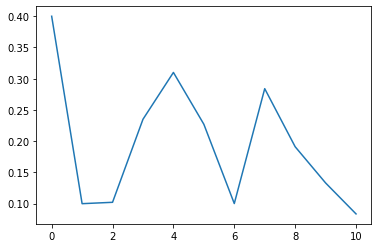

In [44]:
#Einfaches Einzelbeispiel
plt.plot(df['valence_list'][0])

Plot von allen Kurven

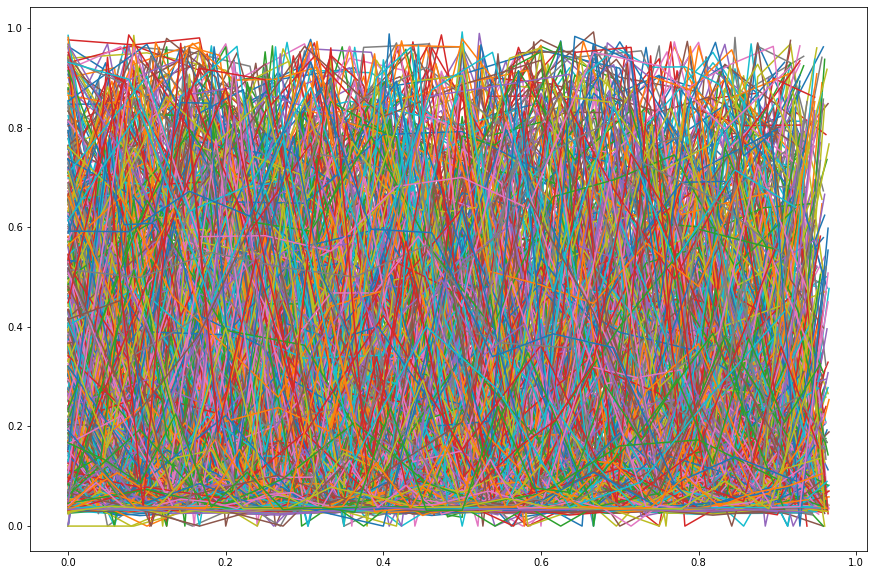

In [45]:
plt.figure(figsize=(15,10))
for i in range(0,len(df)):
    x = [j/len(df['valence_list'][i]) for j in range(len(df['valence_list'][i]))]
    y = df['valence_list'][i]
    plt.plot(x,y)
    
plt.show()

Plot von Filmen mit dem Genre Fantasy

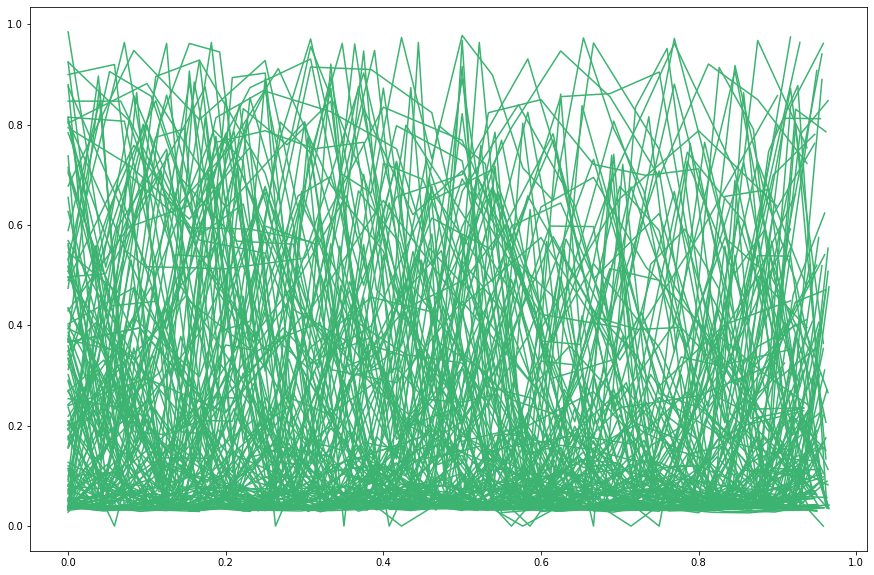

In [46]:
plt.figure(figsize=(15,10))
for film in list(genres_dataframes['Fantasy']['valence_list']):
    x = [j/len(film) for j in range(len(film))]
    y = film
    plt.plot(x,y, c='mediumseagreen')
plt.show()

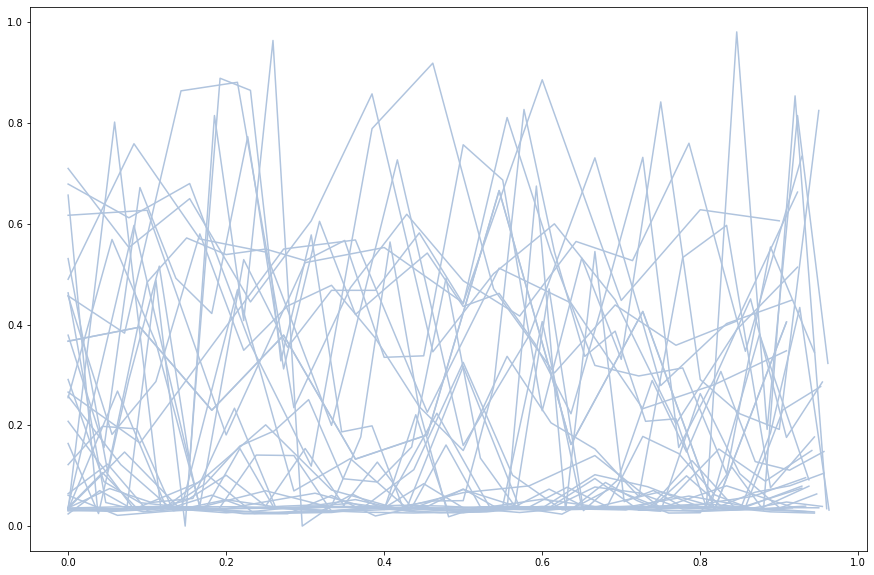

In [47]:
plt.figure(figsize=(15,10))
for f in list(genres_dataframes['Horror']['valence_list']):
    x = x = [j/len(f) for j in range(len(f))]
    y = f
    plt.plot(x,y,color='lightsteelblue')
plt.show()

Plot von einem Genre als Scatterplot

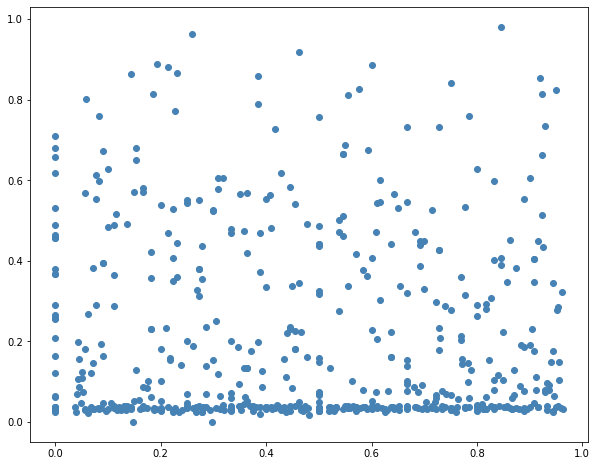

In [48]:
plt.figure(figsize=(10,8))
for f in list(genres_dataframes['Horror']['valence_list']):
    x = [j/len(f) for j in range(len(f))]
    y = f
    plt.scatter(x,y, c='steelblue')
plt.show()

In [49]:
genre_list = list(clean_set)
genre_list

['Comedy',
 'Short',
 'Music',
 'Mystery',
 'Documentary',
 'War',
 'Adventure',
 'Western',
 'Sci-Fi',
 'Reality-TV',
 'Romance',
 'Talk-Show',
 'Musical',
 'Sport',
 'Action',
 'Biography',
 'Drama',
 'Animation',
 'History',
 'Fantasy',
 'Family',
 'Thriller',
 'Crime',
 'None',
 'Horror']

#### Visualisierungen von Emotion Arcs nach Genres Tags

Darstellung einzelner Genres als Valenz-Kurven anhand von IMDB Tags

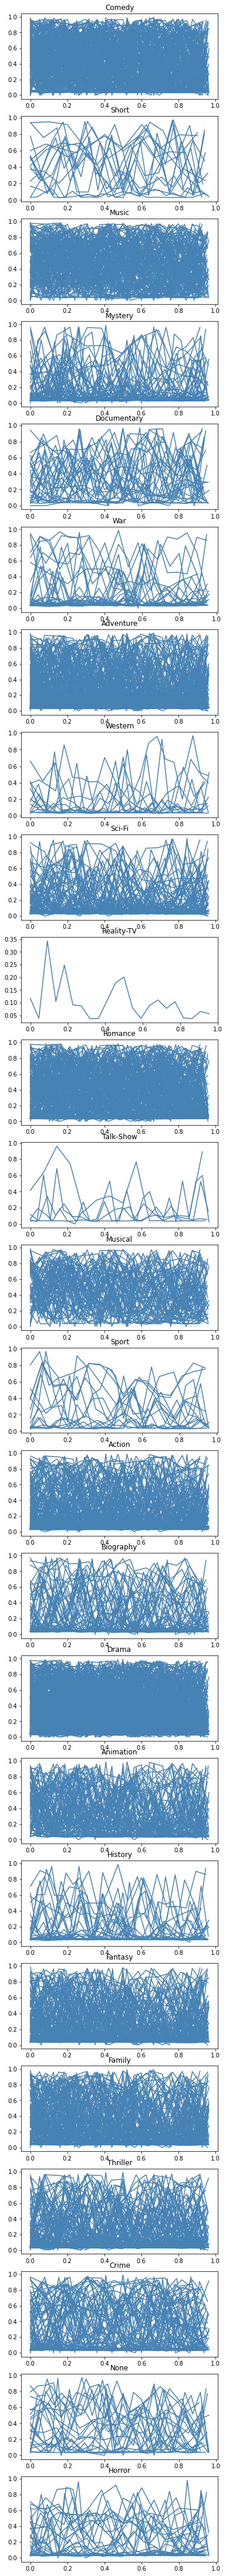

In [50]:
fig, axs = plt.subplots(len(clean_set),1,figsize=(6,80))
for num, ax in enumerate (fig.get_axes()):
    for film in list(genres_dataframes[genre_list[num]]['valence_list']):
        x = [j/len(film) for j in range(len(film))]
        y = film
        ax.set_title(genre_list[num])
        ax.plot(x,y, c='steelblue')

### Schritt 3: Genre-Specific Emotion Curves

[Paper als Vorbild](https://dh2017.adho.org/abstracts/203/203.pdf)

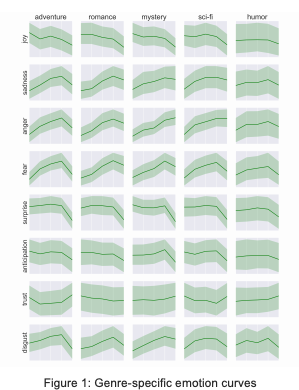

Zusammenfassen der Kurven aus einzelnen Genres zu einer Kurve

**Beispiel für ein Genre -> Valence**

In [122]:
fantasy_valence_lst = list(genres_dataframes['Fantasy']['valence_list'])

In [123]:
fantasy_valence_lst[0]

[0.341,
 0.7,
 0.595,
 0.592,
 0.567,
 0.173,
 0.65,
 0.711,
 0.369,
 0.697,
 0.962,
 0.707,
 0.0999]

In [124]:
testing_list = []

for values in fantasy_valence_lst:
    #Input: list mit values für einen Film
    #Output: list mit korrespondierenden prozentualen Angaben auf zwei Nachkommastellen gerundet
    percent_list = list(map(lambda x: round(values.index(x)/len(values),1), values)) 
    values_percent = list(zip(percent_list,values))
    testing_list.append(values_percent)

In [125]:
indexlist = [i/100 for i in range(0,100)]

In [126]:
from collections import defaultdict 

In [127]:
new_dict = defaultdict(list) 

In [129]:
for values in testing_list:
    for onetuple in values:
        #print(onetuple[0])
        new_dict[onetuple[0]].append(onetuple[1])

In [130]:
from statistics import mean 

In [131]:
new_dict = {k: round(mean(v),3) for k, v in new_dict.items()}

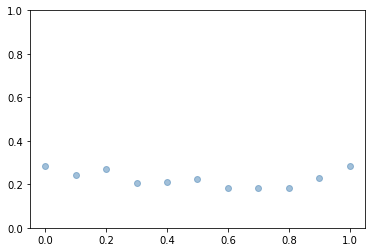

In [132]:
for x,y in new_dict.items():
    plt.scatter(x,y,color='steelblue',alpha=0.5)
    plt.ylim(0,1)

In [133]:
x_values = []
y_values = []
for x,y in sorted(new_dict.items()):
    x_values.append(x)
    y_values.append(y)
plt.plot(x_values,y_values)
plt.ylim(0,1)

In [150]:
def scatter_to_curve(genre_dict):
    x_values = []
    y_values = []
    for x,y in sorted(new_dict.items()):
        x_values.append(x)
        y_values.append(y)
    plt.plot(x_values,y_values)
    plt.ylim(0,1)

**Vergleichende Darstellung für alle Genres**

In [139]:
def create_values(genre_valence_list):
    valence_time_list = []

    for values in genre_valence_list:
        percent_list = list(map(lambda x: round(values.index(x)/len(values),1), values)) 
        values_percent = list(zip(percent_list,values))
        valence_time_list.append(values_percent)
    return valence_time_list

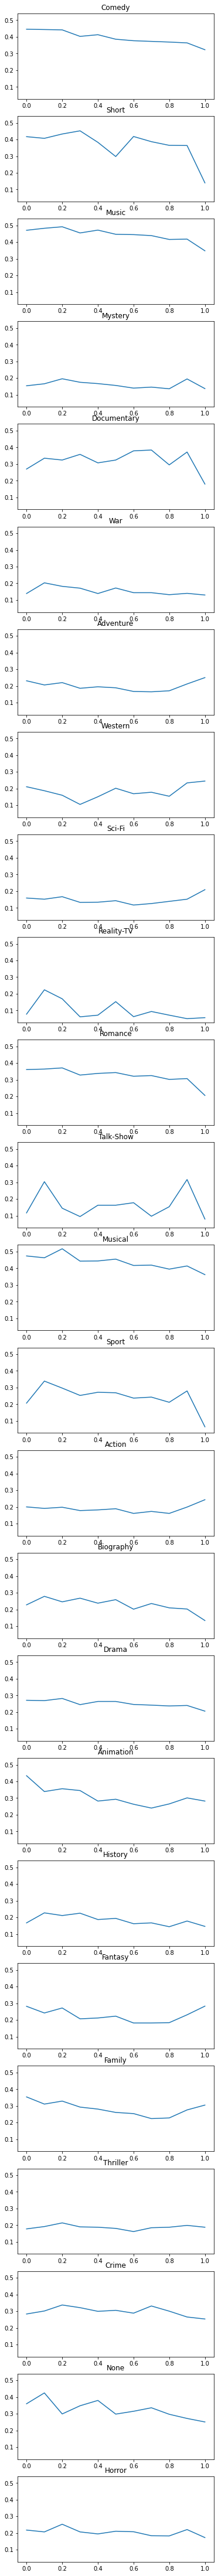

In [152]:
fig, axs = plt.subplots(len(clean_set),1,figsize=(6,80),sharey=True)

for num, ax in enumerate (fig.get_axes()):
    genre_valence_list = list(genres_dataframes[genre_list[num]]['valence_list'])
    valence_time_list = create_values(genre_valence_list)
    
    genre_dict = defaultdict(list) 
    
    for values in valence_time_list:
        for one_tuple in values:
            genre_dict[one_tuple[0]].append(one_tuple[1])
            
    genre_dict = {k: round(mean(v),3) for k, v in genre_dict.items()}

    # Ziel: plotten von der zusammengefassten Kurve in Bezug auf ein Genre
    ax.set_title(genre_list[num])
    
    #for x,y in genre_dict.items():
    #    ax.scatter(x,y, c='steelblue')   
    
    x_values = []
    y_values = []
    for x,y in sorted(genre_dict.items()):
        x_values.append(x)
        y_values.append(y)
    ax.plot(x_values,y_values)